<a href="https://colab.research.google.com/github/eraldoribeiro/cse5280_animation_by_cost_function_minimization/blob/main/animation_by_cost_minimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animation by cost-function minimization

The method described in this notebook is based on the paper by Breen (1997):

- Breen, D. (1997). Cost minimization for animated geometric models in computer graphics. Journal of Visualization and Computer Animation, Vol. 8, No. 4, 1997, pp. 201-220 ([pdf](https://www.cs.drexel.edu/~deb39/Papers/cost_min.pdf)).

Breen's paper proposes a cost-minimization method for creating animations. The cost function incorporates terms for goal attraction, obstacle avoidance, and other constraints. The motion is goal-oriented with added constraints that change the topography of the cost function. As a result, creating the animation becomes a task of defining a function.

In the paper, the first example of animation is the motion of a single particle on the plane like the one shown in Figure 1.

![single-particle animation](https://cs.fit.edu/~eribeiro/teaching/cse5280/figs/find_path.jpg)


**Figure 1**: Animation of the motion of a single particle moving through a set of obstacles. Figure from
(Breen 1997).

## The cost function
The single particle animation is achieved by minimizing the following cost function:

$$
\begin{align}
	C\left({\bf x}\right) = \|{\bf x} - {\bf g}\| + \sum_{i=1}^{n} F\left(\|{\bf x} - {\bf o}_i\|\right),
	%\label{costFunction}
\end{align}
$$

where ${\bf x}$ is the current location of the animated object, ${\bf g}$ is the goal location, ${\bf o}_i$ is the location of obstacle $i$, and $F$ is a penalty field for collision avoidance. The penalty field $F$ is given by:

$$
\begin{align}
        F\left(d\right) =
	\begin{cases}
		\ln\left(R/d\right), & 0 < d \leq R,\\
		0,                         &d > R.
	\end{cases}
	%\label{field_function1}
\end{align}
$$

where $R$ is the radius of the obstacle. When designing the animation, we need to set the value of the goal location ${\bf g}$, the radius of the obstacles, $R_i$, and their location ${\bf o}_i$.

The animation path is then obtained by the gradient-descent algorithm:

$$
\begin{align}
        {\bf x}_{t+1} = {\bf x}_{t} - \lambda \nabla C({\bf x}_{t}), && \text{for} &&  t \geq 0,
\end{align}
$$
where $\nabla C({\bf x}_{t})$ is the gradient of the cost function calculated at ${\bf x}_{t}$.

Next, let us look at the implementation of the two components of the cost function: the attraction term and the obstacle-avoidance term.

### Attraction term of the cost function

The following is an illustration of the attraction term in Equation 1, calculated over a subset of spatial domain.
    

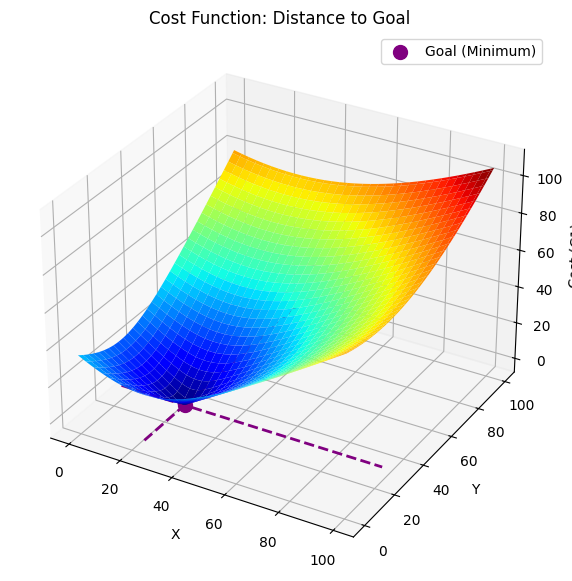

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the goal location
g = np.array([25, 25])

# Create meshgrid for the X and Y coordinates
X, Y = np.meshgrid(np.arange(0, 101, 1), np.arange(0, 101, 1))

# Set Gx and Gy to be the goal location for all points in the grid
Gx = np.full_like(X, g[0])
Gy = np.full_like(Y, g[1])

# Calculate the attraction term (distance to the goal)
C1 = np.sqrt((X - Gx)**2 + (Y - Gy)**2)

# Plotting the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, C1, cmap='jet')

# Mark the minimum point (goal location) on the x, y plane
ax.scatter(g[0], g[1], 0, color='purple', s=100, label="Goal (Minimum)")

# Add dashed red lines indicating the position of the minimum
# Dashed line along x-axis (y = g[1])
ax.plot([g[0], g[0]], [0, 100], [0, 0], color='purple', linestyle='--', linewidth=2)

# Dashed line along y-axis (x = g[0])
ax.plot([0, 100], [g[1], g[1]], [0, 0], color='purple', linestyle='--', linewidth=2)

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Cost (C1)')
ax.set_title('Cost Function: Distance to Goal')

# Show legend
ax.legend()

# Show the plot
plt.show()


The plot shows the location of the minimum, which is the selected goal location.

### The gradient of the attraction term
The example shows the calculation of the gradient vector field of the attraction term. The gradient represents the "slope" of the tangent plane to the cost function at a given position $(x,y)$.

#### Gradient vector field
The gradient vectors, $\nabla(x,y) = (u,v)$ point towards the growth of the function.

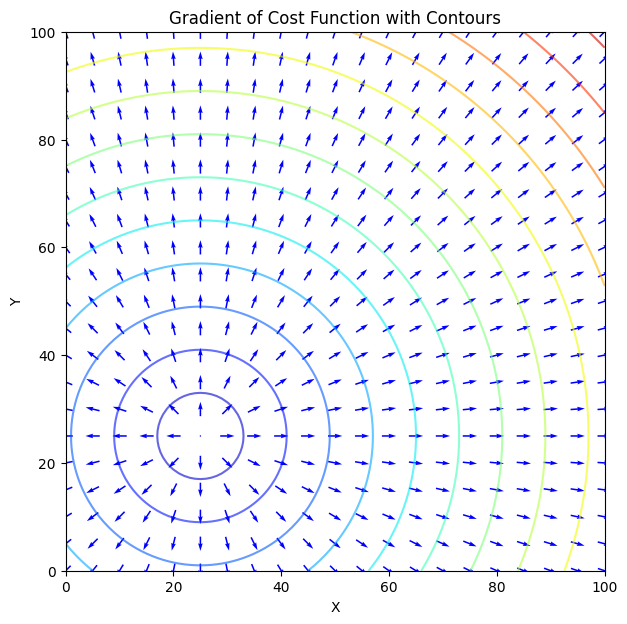

In [3]:
# Define the goal location
g = np.array([25, 25])

# Create meshgrid for the X and Y coordinates
X, Y = np.meshgrid(np.arange(0, 101, 1), np.arange(0, 101, 1))

# Set Gx and Gy to be the goal location for all points in the grid
Gx = np.full_like(X, g[0])
Gy = np.full_like(Y, g[1])

# Calculate the attraction term (distance to the goal)
C1 = np.sqrt((X - Gx)**2 + (Y - Gy)**2)

# Display the gradient vector field with contour lines
delta = 5  # Spacing between the arrows

# Calculate the gradient of the cost function (C1)
DY, DX = np.gradient(C1)

# Create a sample grid to display arrows spaced by delta
X1, Y1 = np.meshgrid(np.arange(0, X.shape[1], delta), np.arange(0, Y.shape[0], delta))

# Plot the gradient vector field using quiver plot
fig, ax = plt.subplots(figsize=(10, 7))

# Add contour lines
contour = ax.contour(X, Y, C1, levels=15, cmap='jet', alpha=0.6)

# Add gradient vectors as arrows
ax.quiver(X1, Y1, DX[::delta, ::delta], DY[::delta, ::delta], color='b', pivot='mid')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gradient of Cost Function with Contours')
ax.set_aspect('equal')

# Display the plot
plt.show()


#### Inverse gradient vector field
We want the inverse of the gradient vector field to guide the iteration of the animation. The following code calculates the inverse gradient (i.e., negative gradient).

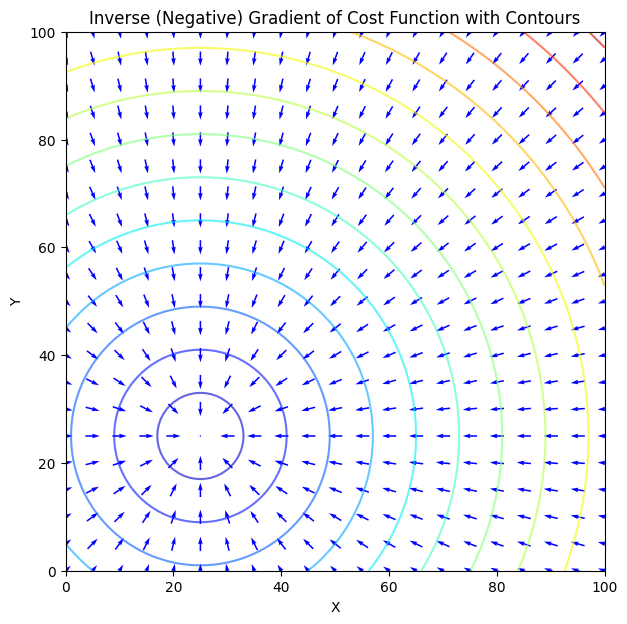

In [4]:
# Define the goal location
g = np.array([25, 25])

# Create meshgrid for the X and Y coordinates
X, Y = np.meshgrid(np.arange(0, 101, 1), np.arange(0, 101, 1))

# Set Gx and Gy to be the goal location for all points in the grid
Gx = np.full_like(X, g[0])
Gy = np.full_like(Y, g[1])

# Calculate the attraction term (distance to the goal)
C1 = np.sqrt((X - Gx)**2 + (Y - Gy)**2)

# Display the gradient vector field with contour lines
delta = 5  # Spacing between the arrows

# Calculate the gradient of the cost function (C1)
DY, DX = np.gradient(C1)

DX_inv = -DX
DY_inv = -DY

# Create a sample grid to display arrows spaced by delta
X1, Y1 = np.meshgrid(np.arange(0, X.shape[1], delta), np.arange(0, Y.shape[0], delta))

# Plot the gradient vector field using quiver plot
fig, ax = plt.subplots(figsize=(10, 7))

# Add contour lines
contour = ax.contour(X, Y, C1, levels=15, cmap='jet', alpha=0.6)

# Add gradient vectors as arrows
ax.quiver(X1, Y1, DX_inv[::delta, ::delta], DY_inv[::delta, ::delta], color='b', pivot='mid')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Inverse (Negative) Gradient of Cost Function with Contours')
ax.set_aspect('equal')

# Display the plot
plt.show()

### Penalty function for obstacle avoidance
This term represents the field potential that will push the particle away from obstacles that are located along the way to the goal.

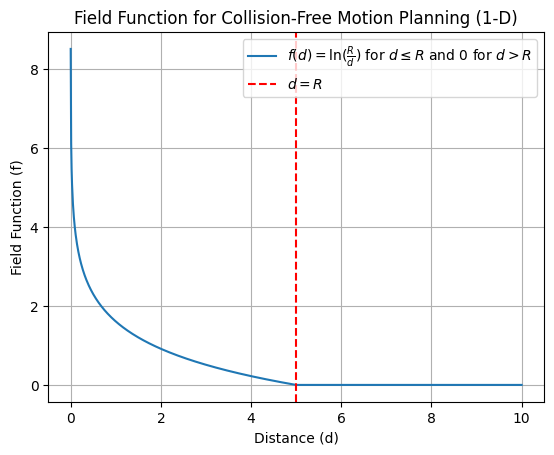

In [5]:
# Define the Field (penalty) function for collision-free motion
def F(d, R):
    # If 0 < d <= R, f = ln(R/d)
    f = np.log(R / (d + 0.001))

    # Replace NaNs or infinities for d == 0 with a small value
   # f[d == 0] = np.log(R / 0.001)

    # If d > R, set f(d) = 0
    f[d > R] = 0

    return f

# Define parameters
R = 5  # Example radius of influence
d_values = np.linspace(0, 10, 1000)  # Distance values from 0 to 10

# Compute the function values
f_values = F(d_values, R)

# Plot the result
plt.plot(d_values, f_values, label=r'$f(d) = \ln(\frac{R}{d})$ for $d \leq R$ and 0 for $d > R$')
plt.xlabel('Distance (d)')
plt.ylabel('Field Function (f)')
plt.title('Field Function for Collision-Free Motion Planning (1-D)')
plt.axvline(x=R, color='red', linestyle='--', label=r'$d = R$')
plt.legend()
plt.grid(True)
plt.show()

#### Calculating the penalty function over the $xy$-domain

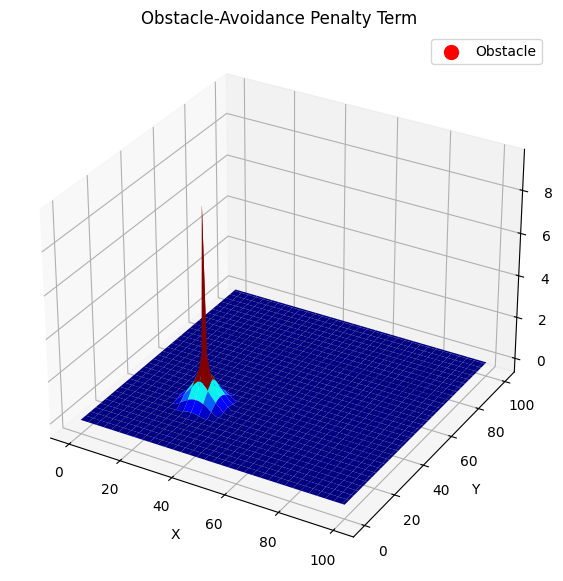

In [6]:
# Set up the grid
X, Y = np.meshgrid(np.arange(0, 101, 1), np.arange(0, 101, 1))

# Obstacle location and radius
o = np.array([30, 30])  # Obstacle location (x, y)
R = 10  # Obstacle radius

# Distance to the obstacle (d)
Ox = np.full_like(X, o[0])  # x-coordinate of the obstacle
Oy = np.full_like(Y, o[1])  # y-coordinate of the obstacle

d2 = np.sqrt((X - Ox) ** 2 + (Y - Oy) ** 2)  # Distance to the obstacle

# Calculate the cost term using the penalty function
C2 = F(d2, R)

# Plotting the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, C2, cmap='jet')

# Mark the obstacle position (for reference)
ax.scatter(o[0], o[1], 0, color='red', s=100, label="Obstacle", marker="o")

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Penalty (C2)')
ax.set_title('Obstacle-Avoidance Penalty Term')

# Show legend
ax.legend()

# Show the plot
plt.show()

#### The (inverse) gradient of the penalty function

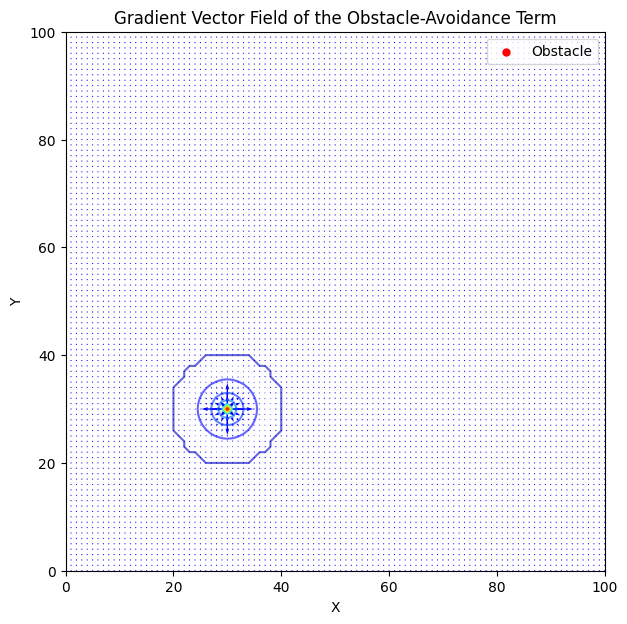

In [7]:
# Set up the grid
X, Y = np.meshgrid(np.arange(0, 101, 1), np.arange(0, 101, 1))

# Distance to the obstacle (d)
Ox = np.full_like(X, o[0])  # x-coordinate of the obstacle
Oy = np.full_like(Y, o[1])  # y-coordinate of the obstacle

d2 = np.sqrt((X - Ox) ** 2 + (Y - Oy) ** 2)  # Distance to the obstacle

# Calculate the cost term using the penalty function
C2 = F(d2, R)

# Compute the gradient of the cost term (C2) with respect to X and Y
dC2_dy, dC2_dx = np.gradient(C2)

# Create a vector field plot (gradient vectors)
fig, ax = plt.subplots(figsize=(10, 7))

# Add contour lines
contour = ax.contour(X, Y, C2, levels=15, cmap='jet', alpha=0.6)

# Plot the gradient vector field using quiver
ax.quiver(X, Y, -dC2_dx, -dC2_dy, color='b', pivot='mid', scale=50)

# Add the obstacle marker
ax.scatter(o[0], o[1], color='red', s=25, label="Obstacle", marker="o")

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gradient Vector Field of the Obstacle-Avoidance Term')
ax.set_aspect('equal')

# Show the legend
ax.legend()

# Display the plot
plt.show()


### Combining the terms
In the following example, we combine the two costs to form the single cost function.

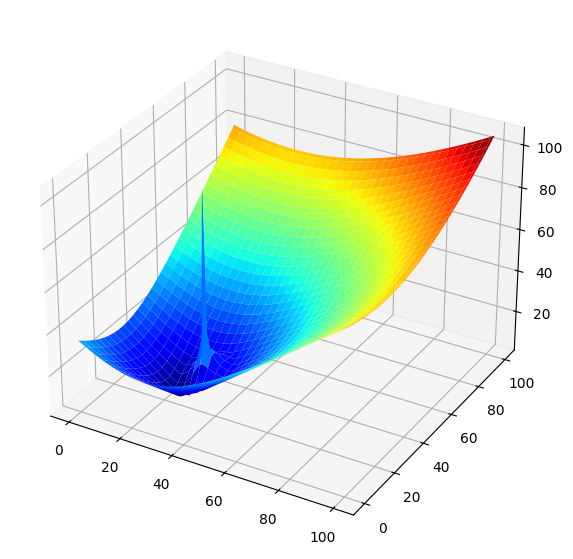

In [8]:
# Overall cost function
# Applying a weight to the obstacle-avoidance term to make it more significant in the cost function
w = 10  # Weight for the obstacle-avoidance term
C = C1 + w * C2

# Plotting the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # 3D plot
ax.plot_surface(X, Y, C, cmap='jet')  # Surface plot

### The gradient of the combined cost

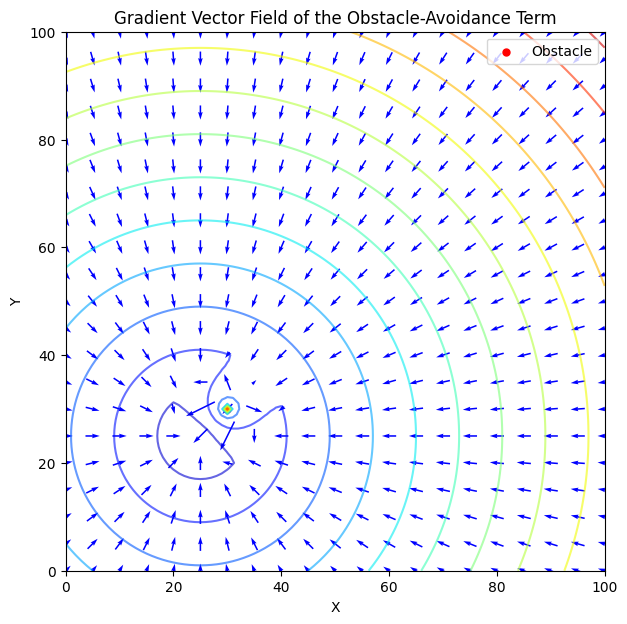

In [9]:
# Set up the grid
X, Y = np.meshgrid(np.arange(0, 101, 1), np.arange(0, 101, 1))

# Compute the gradient of the cost term (C2) with respect to X and Y
dC_dy, dC_dx = np.gradient(C)

# Create a vector field plot (gradient vectors)
fig, ax = plt.subplots(figsize=(10, 7))

# Add contour lines
contour = ax.contour(X, Y, C, levels=15, cmap='jet', alpha=0.6)

# Display the gradient vector field with contour lines
delta = 5  # Spacing between the arrows

# Create a sample grid to display arrows spaced by delta
X1, Y1 = np.meshgrid(np.arange(0, X.shape[1], delta), np.arange(0, Y.shape[0], delta))

# Add gradient vectors as arrows
ax.quiver(X1, Y1, -dC_dx[::delta, ::delta], -dC_dy[::delta, ::delta], color='b', pivot='mid')

# Plot the gradient vector field using quiver
# ax.quiver(X, Y, -dC_dx, -dC_dy, color='b', pivot='mid', scale=50)

# Add the obstacle marker
ax.scatter(o[0], o[1], color='red', s=25, label="Obstacle", marker="o")

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gradient Vector Field of the Obstacle-Avoidance Term')
ax.set_aspect('equal')

# Show the legend
ax.legend()

# Display the plot
plt.show()

## Robot arm cost function

The second example described in Breen's paper is the animation of a robot arm. Similar to the single-particle example, the robot-arm animation is achieved by using the gradient-descent algorithm to solve the following minimization problem:

$$
\begin{align}
	\hat{\bf \Phi} = \arg_{{{\bf \Phi}}}\min  C\left({\bf \Phi}\right).
	%\label{simple_motion_min}
\end{align}
$$

In the robot-arm case, the cost function, $C$, has an extra penalty term to control the range-of-motion limits of the joints. The cost function is defined by:

$$
\begin{align}
	C\left({\bf \Phi}\right) = |{\bf e}\left({\bf \Phi}\right) - {\bf g}\| + \sum_{i=1}^{n} F_R\left(\|{\bf e}\left({\bf \Phi}\right) - {\bf o}_i\|\right) + \sum_{j=1}^{3} L\left(\phi_j\right).
	%\label{simple_motion}
\end{align}
$$

Here, ${\bf g} = \left(x_g, y_g, z_g\right)^\mathsf{T}$ is the *goal location*, ${\bf o}_i$ is the location of obstacle $i$. Function ${\bf e}\left({\bf \Phi}\right)$ computes the arm's *forward kinematics* and returns the location of the arm's tip ${\bf e} = \left( e_x, e_y, e_z \right)^\mathsf{T}$, i.e., the *end-effector,* given the arm's joint angles, ${\bf \Phi} = \left( \phi_1, \phi_2,  \phi_3, \phi_4\right)^\mathsf{T}$.   Function ${F}_R$ is a collision-avoidance penalty field. It penalizes poses that take the end effector too close to an obstacle, i.e., beyond a pre-defined distance $R$. The third component of the cost function limits the range of each joint angle. Function ${L}$ is another penalty function. Its value increases as the joint angle $\phi_j$ approaches its maximum or minimum limit. Outside these limits, ${L}$ vanishes.


## Limiting the range of motion of the joints

The limit function constrains the range of motion of the joints (i.e., angles), and is given by:

$$
\begin{align}
        {L}\left(\phi\right) =
	\begin{cases}
		\ln\left(\delta/\left(\phi-\phi_\text{min}\right)\right), & \phi_\text{min} < \phi \leq \phi_\text{min} + \delta\\
		0,                         & \phi_\text{min} + \delta < \phi < \phi_\text{max} - \delta\\
		\ln\left(\delta/\left(\phi_\text{max} - \phi\right)\right), & \phi_\text{max} - \delta \leq \phi < \phi_\text{max},\\
	\end{cases}
	%\label{limit_function}
\end{align}
$$

where $\phi$ is the joint angle, $\phi_\text{min}$ and $\phi_\text{max}$ are the limits of that joint, and $\delta$ is the angular distance from each of the limits after which the limit function vanishes.  


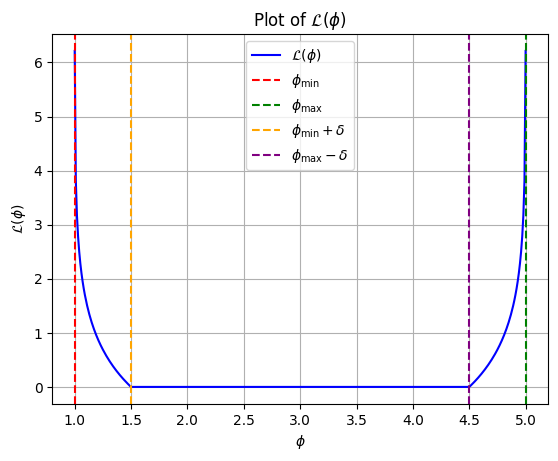

In [10]:
# Join-limiting function
def L_phi(phi, phi_min, phi_max, delta):
    if phi_min < phi <= phi_min + delta:
        return np.log(delta / (phi - phi_min))
    elif phi_min + delta < phi < phi_max - delta:
        return 0
    elif phi_max - delta <= phi < phi_max:
        return np.log(delta / (phi_max - phi))
    else:
        return np.nan  # Outside the range of interest

# Set parameters for phi_min, phi_max, and delta
phi_min = 1.0
phi_max = 5.0
delta = 0.5

# Generate a range of phi values for plotting
phi_values = np.linspace(phi_min - 0.5, phi_max + 0.5, 500)

# Apply the function to each value of phi
L_values = np.array([L_phi(phi, phi_min, phi_max, delta) for phi in phi_values])

# Plot the function
plt.plot(phi_values, L_values, label=r'$\mathcal{L}(\phi)$', color='blue')
plt.axvline(x=phi_min, color='red', linestyle='--', label=r'$\phi_{\text{min}}$')
plt.axvline(x=phi_max, color='green', linestyle='--', label=r'$\phi_{\text{max}}$')
plt.axvline(x=phi_min + delta, color='orange', linestyle='--', label=r'$\phi_{\text{min}} + \delta$')
plt.axvline(x=phi_max - delta, color='purple', linestyle='--', label=r'$\phi_{\text{max}} - \delta$')

# Add labels and legend
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\mathcal{L}(\phi)$')
plt.title(r'Plot of $\mathcal{L}(\phi)$')
plt.legend(loc='best')
plt.grid(True)
plt.show()
